<a href="https://colab.research.google.com/github/laribar/TechChallenge2/blob/main/TechChallenge_2_Rev01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
# Análise de dados e manipulação
import numpy as np
import pandas as pd
import yfinance as yf  # Adicionado para download de dados financeiros

# Visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning e Estatística
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller  # Para teste de estacionariedade

# Manipulação de datas
from datetime import datetime
from pandas.tseries.offsets import BDay

# Configurações e utilitários
import warnings
import logging
from tqdm import tqdm  # Para barras de progresso

# Configuração de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Ignorar warnings
warnings.filterwarnings('ignore')

# Verificação de versões (opcional)
import sklearn
import statsmodels
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Statsmodels version: {statsmodels.__version__}")



Scikit-learn version: 1.6.1
Statsmodels version: 0.14.4


In [157]:
# Baixar dados do Ibovespa desde 1994
print("Baixando dados...")
df = yf.download('^BVSP', start='1994-07-01', end=datetime.now().strftime('%Y-%m-%d'))

# Verificar valores nulos
print("Valores nulos antes do preenchimento:")
print(df.isnull().sum())

# Pré-processamento
df = df.ffill()  # Preencher valores ausentes


[*********************100%***********************]  1 of 1 completed

Baixando dados...
Valores nulos antes do preenchimento:
Price   Ticker
Close   ^BVSP     0
High    ^BVSP     0
Low     ^BVSP     0
Open    ^BVSP     0
Volume  ^BVSP     0
dtype: int64


In [158]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,^BVSP,^BVSP,^BVSP,^BVSP,^BVSP
Date,,,,,
1994-07-04,3580.899902,3712.100098,3579.699951,3623.199951,0
1994-07-05,3564.300049,3599.600098,3486.000000,3580.899902,0
1994-07-06,3753.500000,3781.600098,3564.300049,3564.300049,0
1994-07-07,3905.000000,3923.300049,3753.500000,3753.500000,0
1994-07-08,4051.899902,4051.899902,3860.699951,3905.000000,0


In [159]:
import numpy as np
import pandas as pd

# Supondo que você já tenha carregado seu DataFrame original

# Verifique o DataFrame original
print("Dados originais:")
print(df.head())

# Feature Engineering: executar passo a passo e analisar
try:
    # Calculando Lag Features
    for i in range(1, 6):
        df[f'Lag{i}'] = df['Close'].shift(i)

    print("Após Lags:", df.drop(columns='Close').head())

    # Calculando Retornos Diários
    df['Daily_Return'] = df['Close'].pct_change()

    # Médias Móveis
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()

    # Volatilidade
    df['Volatility'] = df['Close'].pct_change().rolling(window=7).std()

    # Retorno Logarítmico
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Bandas de Bollinger
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    std_dev = df['Close'].rolling(window=20).std()
    df['BB_Upper'] = df['BB_Mid'] + (std_dev * 2)
    df['BB_Lower'] = df['BB_Mid'] - (std_dev * 2)

    # Índice de Força Relativa (RSI)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Mostra uma descrição do depth antes do NaN removal
    print("Antes de dropna():\n", df.head(20))
    print(df.isna().sum())

    # Drop de NaNs depois de verificar todas as mudanças
    df.dropna(inplace=True)

    # Verifique o resultado
    print("Dados após dropna():")
    print(df.head())
except Exception as e:
    print("Erro durante a engineering de features:", str(e))

Dados originais:
Price             Close         High          Low         Open Volume
Ticker            ^BVSP        ^BVSP        ^BVSP        ^BVSP  ^BVSP
Date                                                                 
1994-07-04  3580.899902  3712.100098  3579.699951  3623.199951      0
1994-07-05  3564.300049  3599.600098  3486.000000  3580.899902      0
1994-07-06  3753.500000  3781.600098  3564.300049  3564.300049      0
1994-07-07  3905.000000  3923.300049  3753.500000  3753.500000      0
1994-07-08  4051.899902  4051.899902  3860.699951  3905.000000      0
Após Lags: Price              High          Low         Open Volume         Lag1  \
Ticker            ^BVSP        ^BVSP        ^BVSP  ^BVSP                
Date                                                                    
1994-07-04  3712.100098  3579.699951  3623.199951      0          NaN   
1994-07-05  3599.600098  3486.000000  3580.899902      0  3580.899902   
1994-07-06  3781.600098  3564.300049  3564.3000

In [160]:
# Exemplo: Código para transformar MultiIndex em uma estrutura de colunas única
df.columns = df.columns.get_level_values(0)

# Verificando após ajustes
print("Dados ajustados:")
print(df.head())

# Feature Engineering: Executando de forma mais robusta para DataFrame ajustado
try:
    # Calculando Lag Features
    for i in range(1, 6):
        df[f'Lag{i}'] = df['Close'].shift(i)

    # Calculando Retornos Diários
    df['Daily_Return'] = df['Close'].pct_change()

    # Médias Móveis
    df['MA_7'] = df['Close'].rolling(window=7).mean()
    df['MA_30'] = df['Close'].rolling(window=30).mean()

    # Volatilidade
    df['Volatility'] = df['Close'].pct_change().rolling(window=7).std()

    # Retorno Logarítmico
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

    # Bandas de Bollinger
    df['BB_Mid'] = df['Close'].rolling(window=20).mean()
    std_dev = df['Close'].rolling(window=20).std()

    # Calcular individualmente para evitar erros de atribuição incorreta
    df['BB_Upper'] = df['BB_Mid'] + (std_dev * 2)
    df['BB_Lower'] = df['BB_Mid'] - (std_dev * 2)

    # Índice de Força Relativa (RSI)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # Mostra uma descrição do depth antes do NaN removal
    print("Antes de dropna():\n", df.head(20))
    print(df.isna().sum())

    # Drop de NaNs depois de verificar todas as mudanças
    df.dropna(inplace=True)

    # Verifique o resultado
    print("Dados após dropna():")
    print(df.head())
except Exception as e:
    print("Erro durante a engenharia de features:", str(e))

Dados ajustados:
Price             Close         High          Low         Open  Volume  \
Date                                                                     
1994-07-04  3580.899902  3712.100098  3579.699951  3623.199951       0   
1994-07-05  3564.300049  3599.600098  3486.000000  3580.899902       0   
1994-07-06  3753.500000  3781.600098  3564.300049  3564.300049       0   
1994-07-07  3905.000000  3923.300049  3753.500000  3753.500000       0   
1994-07-08  4051.899902  4051.899902  3860.699951  3905.000000       0   

Price              Lag1         Lag2         Lag3         Lag4  Lag5  \
Date                                                                   
1994-07-04          NaN          NaN          NaN          NaN   NaN   
1994-07-05  3580.899902          NaN          NaN          NaN   NaN   
1994-07-06  3564.300049  3580.899902          NaN          NaN   NaN   
1994-07-07  3753.500000  3564.300049  3580.899902          NaN   NaN   
1994-07-08  3905.000000  3753.50

In [161]:
# Feature Engineering
df['Lag1'] = df['Close'].shift(1)
df['Lag2'] = df['Close'].shift(2)
df['Lag3'] = df['Close'].shift(3)
df['Lag4'] = df['Close'].shift(4)
df['Lag5'] = df['Close'].shift(5)
df['Daily_Return'] = df['Close'].pct_change()

# Criar features
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['Volatility'] = df['Close'].pct_change().rolling(window=7).std()
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

# Bandas de Bollinger
df['BB_Mid'] = df['Close'].rolling(window=20).mean()
std_dev = df['Close'].rolling(window=20).std().squeeze()
df['BB_Upper'] = df['BB_Mid'] + (std_dev * 2)
df['BB_Lower'] = df['BB_Mid'] - (std_dev * 2)

# Índice de Força Relativa (RSI)
delta = df['Close'].diff(1)
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Remover valores nulos remanescentes
df.dropna(inplace=True)
print("Dados após dropna:", len(df))

# Definir variáveis preditoras e alvo
X = df.drop(columns=['Close'])
y = df['Close']

Dados após dropna: 7531


In [162]:
df.head(
)

Price,Close,High,Low,Open,Volume,Lag1,Lag2,Lag3,Lag4,Lag5,Daily_Return,MA_7,MA_30,Volatility,Log_Return,BB_Mid,BB_Upper,BB_Lower,RSI
Date,,,,,,,,,,,,,,,,,,,
1994-09-23,5453.200195,5512.100098,5395.200195,5395.200195,0,5395.200195,5305.899902,5177.399902,5291.799805,5293.700195,0.010750,5314.957171,5216.600016,0.021104,0.010693,5308.495020,5649.159100,4967.830940,52.264444
1994-09-26,5265.100098,5495.600098,5241.299805,5453.200195,0,5453.200195,5395.200195,5305.899902,5177.399902,5291.799805,-0.034494,5311.757185,5240.533350,0.021104,-0.035102,5311.035034,5649.492346,4972.577723,65.198755
1994-09-27,5217.500000,5296.100098,5180.600098,5265.100098,0,5265.100098,5453.200195,5395.200195,5305.899902,5177.399902,-0.009041,5300.871443,5259.416683,0.021328,-0.009082,5305.755029,5646.705431,4964.804628,58.291045
1994-09-28,5277.100098,5324.399902,5199.899902,5217.500000,0,5217.500000,5265.100098,5453.200195,5395.200195,5305.899902,0.011423,5298.771484,5277.183350,0.021924,0.011358,5300.625024,5639.974547,4961.275502,50.216263
1994-09-29,5442.600098,5442.600098,5277.100098,5277.100098,0,5277.100098,5217.500000,5265.100098,5453.200195,5395.200195,0.031362,5336.657227,5292.973356,0.022433,0.030880,5306.280029,5651.376367,4961.183691,53.682090


In [163]:
# Definir variáveis preditoras e alvo
X = df.drop(columns=['Close'])
y = df['Close']

# Dividir o conjunto de dados para treino e previsão
train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [164]:
#REGRESSÃO LINEAR
# Escalonar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Treinar o modelo de Regressão Linear
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)

# Previsões
linear_predictions = linear_model.predict(X_test_scaled)

In [165]:
#RANDOM FOREST

# Treinar o modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Previsões
rf_predictions = rf_model.predict(X_test)

In [166]:
#SARIMA

# Treinar o modelo SARIMA
sarima_order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)
sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=seasonal_order)
sarima_model_fit = sarima_model.fit()

# Previsões
sarima_predictions = sarima_model_fit.forecast(steps=len(y_test))

In [167]:
# Previsão para os próximos 5 dias com modelos treinados:

# Regressão Linear (note que o escalonamento é necessário)
future_features_scaled = scaler.transform(X_test.tail(5))  # usando últimos disponíveis para simular continuações
future_linear_predictions = linear_model.predict(future_features_scaled)

# Random Forest
future_rf_predictions = rf_model.predict(X_test.tail(5))

# ARIMA (baseia-se diretamente em valores passados)
future_arima_predictions = arima_model_fit.forecast(steps=5)

# SARIMA
future_sarima_predictions = sarima_model_fit.forecast(steps=5)

print("Previsões Futuros 5 Dias:")
print("Regressão Linear:", future_linear_predictions)
print("Random Forest:", future_rf_predictions)
print("ARIMA:", future_arima_predictions)
print("SARIMA:", future_sarima_predictions)

Previsões Futuros 5 Dias:
Regressão Linear: [128570.73905353 127688.24714063 127464.33166595 126505.39646746
 125777.86178228]
Random Forest: [97867.72 97754.91 97790.56 97882.28 97860.41]
ARIMA: 6300    113817.175720
6301    113874.596773
6302    113926.291030
6303    113932.614143
6304    113930.395963
Name: predicted_mean, dtype: float64
SARIMA: 6024    98795.709806
6025    98917.971925
6026    98911.564798
6027    98820.669390
6028    99057.469418
Name: predicted_mean, dtype: float64


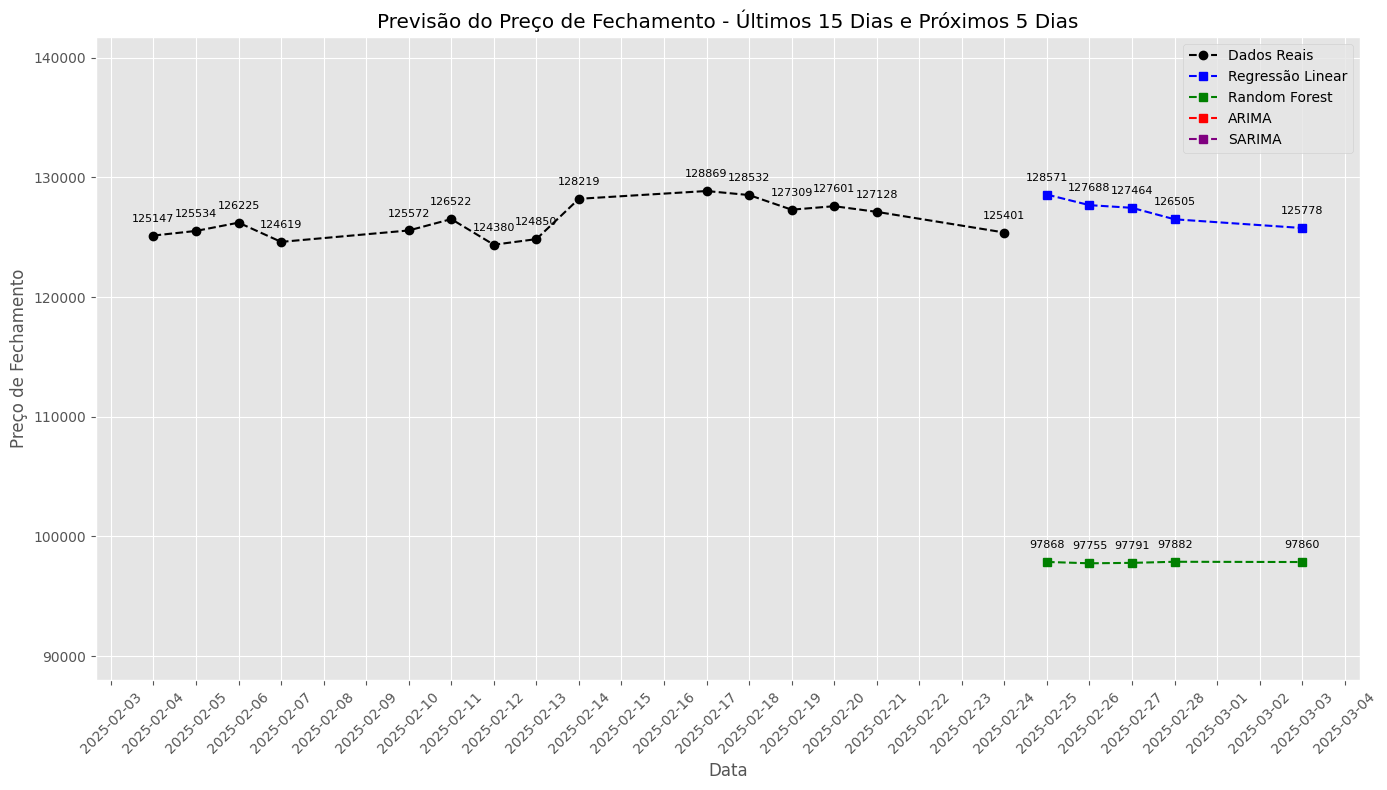

In [176]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Suponha que você já tenha seu DataFrame 'df' e as previsões prontas

# Obter os últimos 15 dias de seu conjunto de dados
last_15_days = df['Close'].tail(15)

# Criar as datas para os próximos 5 dias
future_dates = pd.date_range(start=last_15_days.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')
extended_index_real = last_15_days.index.union(future_dates)

# Criar DataFrame combinando dados reais e previsões
combined_df = pd.DataFrame(index=extended_index_real)
combined_df['Dados Reais'] = pd.concat([last_15_days, pd.Series([None] * 5, index=future_dates)], ignore_index=False)

# Preenchendo previsões apenas para os próximos 5 dias
prediction_index = future_dates

combined_df['Regressão Linear'] = pd.concat([pd.Series([None]*15, index=last_15_days.index), pd.Series(future_linear_predictions, index=prediction_index)])
combined_df['Random Forest'] = pd.concat([pd.Series([None]*15, index=last_15_days.index), pd.Series(future_rf_predictions, index=prediction_index)])
combined_df['ARIMA'] = pd.concat([pd.Series([None]*15, index=last_15_days.index), pd.Series(future_arima_predictions, index=prediction_index)])
combined_df['SARIMA'] = pd.concat([pd.Series([None]*15, index=last_15_days.index), pd.Series(future_sarima_predictions, index=prediction_index)])

# Plotagem
plt.figure(figsize=(14, 8))
markers = {'Dados Reais': 'o', 'Regressão Linear': 's', 'Random Forest': 's', 'ARIMA': 's', 'SARIMA': 's'}
colors = {'Dados Reais': 'black', 'Regressão Linear': 'blue', 'Random Forest': 'green', 'ARIMA': 'red', 'SARIMA': 'purple'}

for column, marker in markers.items():
    plt.plot(combined_df.index, combined_df[column], label=column, color=colors[column], linestyle='--', marker=marker)

    # Adicionar rótulos aos dados
    for x, y in zip(combined_df.index, combined_df[column]):
        if y is not None:  # Apenas rotular se não for None
            plt.annotate(f'{y:.0f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

# Ajuste dos limites do eixo y para que tudo seja visível
plt.ylim(combined_df.min().min() * 0.9, combined_df.max().max() * 1.1)

# Formatação do gráfico
plt.title('Previsão do Preço de Fechamento - Últimos 15 Dias e Próximos 5 Dias')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.legend()
plt.grid(True)

# Mostrar o gráfico
plt.tight_layout()
plt.show()

In [178]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Suponha que 'y_test' contenha os valores reais dos dados futuros
# Pegue os últimos 5 valores de y_test para representar y_true
y_true = y_test[:5].tolist()  # Ajustar conforme necessário dependendo de como y_test está ordenado

# Função auxiliar para calcular todas as métricas
def calculate_errors(true_values, predicted_values, model_name="Modelo"):
    mae = mean_absolute_error(true_values, predicted_values)
    mse = mean_squared_error(true_values, predicted_values)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100

    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Avaliação de cada modelo
calculate_errors(y_true, future_linear_predictions, "Regressão Linear")
calculate_errors(y_true, future_rf_predictions, "Random Forest")
calculate_errors(y_true, future_arima_predictions, "ARIMA")
calculate_errors(y_true, future_sarima_predictions, "SARIMA")

Regressão Linear - MAE: 31779.52, MSE: 1011161129.88, RMSE: 31798.76, MAPE: 33.33%
Random Forest - MAE: 2586.69, MSE: 7942384.35, RMSE: 2818.22, MAPE: 2.73%
ARIMA - MAE: 18474.41, MSE: 343621870.46, RMSE: 18537.04, MAPE: 19.39%
SARIMA - MAE: 3478.88, MSE: 14507124.37, RMSE: 3808.82, MAPE: 3.67%


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Parâmetros a serem testados
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Inicializar o modelo de Random Forest
rf = RandomForestRegressor()

# Grid Search com CV (Cross Validation)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Treinar com seus dados de treino
grid_search.fit(X_train, y_train)

# Melhor combinação de parâmetros e melhor score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Melhores Parâmetros:", best_params)
print("Melhor Score:", best_score)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
